In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from keras import layers, regularizers, optimizers
from keras.models import Sequential
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import BatchNormalization, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

### CIFAR-10 dataset

- RGB images (3 channels)
- 32x32 pixels
- 10 classes
- Training set: 50,000 images
- Testing set: 10,000 images

In [2]:
%%capture
# Load the CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (50000, 32, 32, 3)
x_test shape: (10000, 32, 32, 3)


#### Data augmentation

- Randomly rotate the images by up to 15 degrees
- Randomly shift the images horizontally and vertically by up to 10% of the image width and height
- Randomly flip the images horizontally

In [4]:
# Create the data augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomTranslation(0.1, 0.1),
], name="data_augmentation")

In [5]:
x_train_aug = data_augmentation(x_train)
x_train_aug = np.array(x_train_aug, dtype=np.uint8)

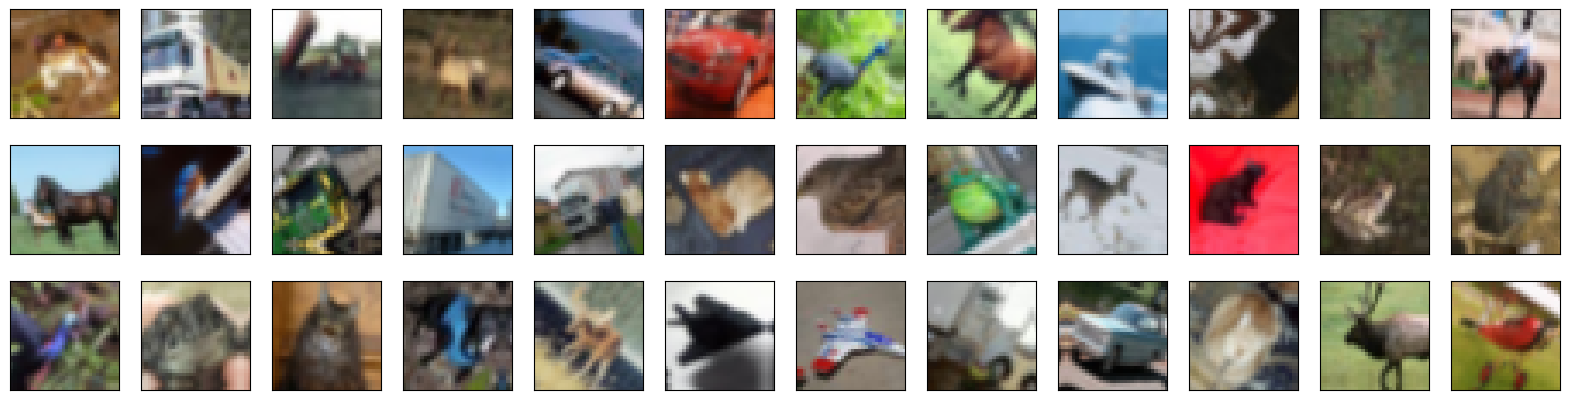

In [6]:
# Visualize the first 36 images
fig = plt.figure(figsize=(20,5)) 
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train_aug[i]))
plt.show()

In [7]:
# Join the augmented images with the original images
x_train = np.concatenate([x_train, x_train_aug], axis=0)
y_train = np.concatenate([y_train, y_train], axis=0)

In [8]:
# Split the training set into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(f'x_train shape: \t{x_train.shape}')
print(f'x_val   shape: \t{x_val.shape}')
print(f'x_test  shape: \t{x_test.shape}')

x_train shape: 	(80000, 32, 32, 3)
x_val   shape: 	(20000, 32, 32, 3)
x_test  shape: 	(10000, 32, 32, 3)


#### Normalize the data

In [9]:
mean = np.mean(x_train, axis=(0, 1, 2, 3))
std = np.std(x_train, axis=(0, 1, 2, 3))
epsilon = 1e-8
x_train = (x_train - mean) / (std + epsilon)
x_val = (x_val - mean) / (std + epsilon)
x_test = (x_test - mean) / (std + epsilon)

# Range of values for the training set
print(f'x_train min: \t{np.min(x_train)}')
print(f'x_train max: \t{np.max(x_train)}')
print(f'x_train mean: \t{np.mean(x_train)}')
print(f'x_train std: \t{np.std(x_train)}')

x_train min: 	-1.9150286698154615
x_train max: 	2.1446874039599577
x_train mean: 	7.485123632022806e-17
x_train std: 	0.9999999998407905


#### One-hot encode the labels

In [10]:
num_classes = np.unique(y_train).shape[0]
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

y_train shape: (80000, 10)
y_val shape: (20000, 10)
y_test shape: (10000, 10)


### CNN model

- Conv layer 1: 32 filters, 3x3 kernel, padding=same
- ReLU activation, Batch normalization, L2 regularization $\lambda=1e-4$
- Conv layer 2: 32 filters, 3x3 kernel, padding=same
- ReLU activation, Batch normalization, L2 regularization $\lambda=1e-4$
- Max Pooling layer: 2x2 kernel, stride=2
- Dropout layer: 0.2
- Conv layer 3: 64 filters, 3x3 kernel, padding=same
- ReLU activation, Batch normalization, L2 regularization $\lambda=1e-4$
- Conv layer 4: 64 filters, 3x3 kernel, padding=same
- ReLU activation, Batch normalization, L2 regularization $\lambda=1e-4$
- Max Pooling layer: 2x2 kernel, stride=2
- Dropout layer: 0.3
- Convolutional layer 5: 128 filters, 3x3 kernel, padding=same
- ReLU activation, Batch normalization, L2 regularization $\lambda=1e-4$
- Convolutional layer 6: 128 filters, 3x3 kernel, padding=same
- ReLU activation, Batch normalization, L2 regularization $\lambda=1e-4$
- Max Pooling layer: 2x2 kernel, stride=2
- Dropout layer: 0.4
- Flatten layer
- Dense layer 1: 10 units, softmax activation

In [11]:
base_hidden_units = 32
weight_decay = 1e-4
regularizer = regularizers.l2(weight_decay)
model = Sequential(name="cifar10_cnn_upgraded")

# INPUT
model.add(Input(shape=(32, 32, 3)))

# CONV1
model.add(Conv2D(base_hidden_units, (3, 3), padding='same', kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units, (3, 3), padding='same', kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(base_hidden_units * 2, (3, 3), padding='same', kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(BatchNormalization()) 

# CONV4
model.add(Conv2D(base_hidden_units * 2, (3, 3), padding='same', kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(base_hidden_units * 4, (3, 3), padding='same', kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(base_hidden_units * 4, (3, 3), padding='same', kernel_regularizer=regularizer))
model.add(Activation('relu'))
model.add(BatchNormalization())

# POOL + Dropout
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# FLATTEN
model.add(Flatten())

# DENSE
model.add(Dense(10, activation='softmax'))

In [12]:
model.summary()

Model: "cifar10_cnn_upgraded"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 309,290 (1.18 MB)

 Trainable params: 308,394 (1.18 MB)

 Non-trainable params: 896 (3.50 KB)

#### Train the model

In [13]:
batch_size = 128
epochs = 40
learning_rate = 1e-4
decay_rate = 1e-6

In [14]:
checkpoint = ModelCheckpoint(filepath='cifar10_cnn_upgraded.keras', monitor='val_loss', 
                             save_best_only=True, verbose=1)

optimizer = optimizers.Adam(learning_rate=learning_rate, weight_decay=decay_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(x_val, y_val), callbacks=[checkpoint])

Epoch 1/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2420 - loss: 3.0426
Epoch 1: val_loss improved from inf to 1.70159, saving model to cifar10_cnn_upgraded.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 109s 171ms/step - accuracy: 0.2420 - loss: 3.0419 - val_accuracy: 0.4105 - val_loss: 1.7016
Epoch 2/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3667 - loss: 2.0063
Epoch 2: val_loss improved from 1.70159 to 1.56366, saving model to cifar10_cnn_upgraded.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/step - accuracy: 0.3667 - loss: 2.0062 - val_accuracy: 0.4536 - val_loss: 1.5637
Epoch 3/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4169 - loss: 1.7872
Epoch 3: val_loss improved from 1.56366 to 1.49667, saving model to cifar10_cnn_upgraded.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 102s 163ms/step - accuracy: 0.4169 - loss: 1.7871 - val_accuracy: 0.4857 - val_loss: 1.4967
Epoch 4/40
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.4583 - loss: 1.6364
Epoc

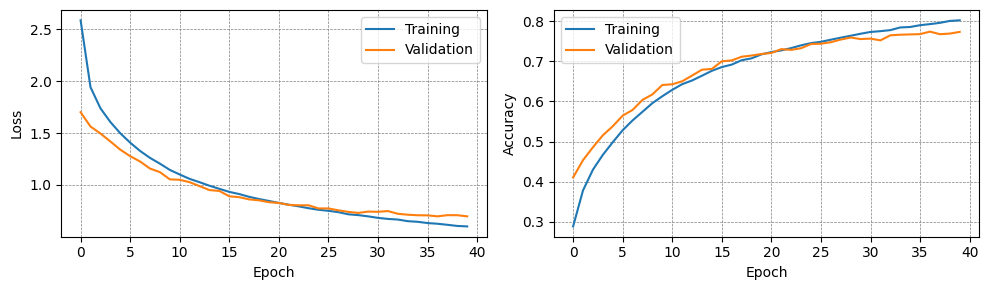

In [16]:
# Plot the training and validation loss
# Plot the training and validation accuracy
# Subplots horizontal

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
axs[0].plot(history.history['loss'], label='Training')
axs[0].plot(history.history['val_loss'], label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(color='gray', linestyle='--', linewidth=0.5)
axs[1].plot(history.history['accuracy'], label='Training')
axs[1].plot(history.history['val_accuracy'], label='Validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(color='gray', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [17]:
scores = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
print("\nTest result: %s: %.3f, %s: %.2f%%" % (model.metrics_names[0], scores[0]*100, 
                                             model.metrics_names[1], scores[1]*100))


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8130 - loss: 0.5890

Test result: loss: 59.296, compile_metrics: 81.44%
